# Taller de Procesamiento de Lenguaje Natural: Recuperación de Información Aplicada a Entrevistas y Libros de la Comisión de la Verdad

**Autores**  
- **Juan Aponte Duque**  
  Pontificia Universidad Javeriana  
  [aponte.juan@javeriana.edu.co](mailto:aponte.juan@javeriana.edu.co)

- **Cristian Cardozo Amin**  
  Pontificia Universidad Javeriana  
  [cristiancardozo@javeriana.edu.co](mailto:cristiancardozo@javeriana.edu.co)

- **Benkos Triana Ocampo**  
  Pontificia Universidad Javeriana  
  [b.triana@javeriana.edu.co](mailto:b.triana@javeriana.edu.co)


## Objetivo 
Desarrollar  un  proceso  de  Recuperación  de  Información  (IR)  para  determinar  qué entrevistas  contenidas  en  el  documento  JSON  están  relacionadas  con testimonios  o  secciones de los libros de la Comisión de la Verdad (CEV). Se espera que los estudiantes  apliquen técnicas de procesamiento de lenguaje natural para analizar y  relacionar  las narraciones  de  entrevistas  con  textos  específicos  de  los  libros,  utilizando  métricas específicas para medir la relevancia de los resultados.

## Recursos:
- **Libros de la Comisión de la Verdad (CEV)**:

[https://drive.google.com/drive/folders/1W9UOdkqnAcztnFZ8xresW4ZeZ2pqXe4v?usp=sharing]
- **Entrevistas**:

[https://drive.google.com/file/d/1XeFS_mQFmTLQ_VUiODTBO5eONWv-Ege5/view?usp=sharing]

- **Tesauro CEV**:

[https://drive.google.com/file/d/1XgZzMtFQp0RzwqdY7Em5q5ProsWLMMX4/view?usp=sharing]

---
---
## Dependecias

In [8]:
import pandas as pd
import sys
from pandarallel import pandarallel

# Inicializar pandarallel
pandarallel.initialize(progress_bar=True)
sys.path.append("../src")
from funciones_nlp import *
from funciones_pdf import *
from funciones_json import *
from funciones_abt import *

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


---
---
## Extracción y Preparación del Corpus

### Extraer las secciones, testimonios o partes relevantes de cada uno de los libros de la CEV.

#### Extraccion Libro "MI CUERPO ES LA VERDAD"

In [2]:
# Ruta del archivo PDF del libro de la CEV
pdf_path = "../data/input/CEV_MI CUERPO ES LA VERDAD_DIGITAL_2022.pdf"

# Página inicial para comenzar la extracción 
START_AFTER_PAGE_1BASED = 37  

# Definición de la estructura del libro para la extracción
schema = {
    "Mujeres": {
        "¿Qué pasó? Significados y  magnitudes de lo sucedido": [
            "La guerra, el territorio y las mujeres",
            "Las violencias sexuales y reproductivas contra niñas y mujeres",
            "Mujeres políticas expulsadas de la democracia",
            "Las mujeres en la guerra: vinculación e impactos en sus vidas y en sus familias",
        ],
        "¿Por qué pasó? Dimensiones del patriarcado": [
            "El contínuum de violencias, una realidad que cambia pero no desaparece",
            "El mandato de las masculinidades guerreras y su relación con el militarismo",
            "La desprotección por parte del Estado en zonas de conflicto",
        ],
        "¿Qué pasó con lo que pasó?": [
            "Impactos del conflicto armado en las mujeres",
            "Afrontamientos de las mujeres víctimas",
            "Resistencias, juntanza y organización: en las mujeres reposa la fuerza de la comunidad",
        ],
        "_end_before": "Epílogo",
        "_boundaries": [
            "¿Por qué pasó? Dimensiones del patriarcado",
            "¿Qué pasó con lo que pasó?",
        ],
    },
    "LGBTIQ+": {
        "¿Qué pasó? Violencias contra las personas LGBTIQ+ en el marco del conflicto armado colombiano": [
            "Una mirada general a las violencias contra las personas LGBTIQ+ en la guerra",
            "Situaciones territoriales ilustrativas de la persecución contra personas LGBTIQ+ en el marco del conflicto armado",
            "La persecución contra personas LGBTIQ+ en el conflicto armado colombiano",
            "Patrones de persecución contra las personas LGBTIQ+ diferenciados según el actor armado",
            "Otras consideraciones",
        ],
        "Los porqués de la persecución contra personas LGBTIQ+": [
            "La herencia colonial como un factor histórico explicativo",
            "Factores socioculturales",
            "Factores institucionales y políticos",
        ],
        "¿Qué pasó con lo que les pasó a las personas LGBTIQ+ en el marco del conflicto armado colombiano?": [
            "Impactos de las violencias contra personas LGBTIQ+",
            "Afrontamientos de personas LGBTIQ+ víctimas del conflicto armado en Colombia",
            "Cuerpos disidentes que resisten y transforman para la paz",
        ],
        "_end_before": "Conclusiones",
        "_boundaries": [
            "Los porqués de la persecución contra personas LGBTIQ+",
            "¿Qué pasó con lo que les pasó a las personas LGBTIQ+ en el marco del conflicto armado colombiano?",
        ],
    },
}

# Función para extraer el DataFrame del PDF según el esquema definido
df_result = extract_dataframe_from_pdf(pdf_path, START_AFTER_PAGE_1BASED, schema, drop_empty=False)
print(df_result.shape)
df_result.head(3)

(21, 4)


,seccion,seccion_principal,subseccion,contenido
0,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,"La guerra, el territorio y las mujeres",Las mujeres viven la guerra en sus territorios...
1,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,Las violencias sexuales y reproductivas contra...,Duele la lengua rota. \n¿Dónde está mi femenin...
2,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,Mujeres políticas expulsadas de la democracia,».\n\n¿qué pasó? significados y magnitudes de ...


#### Extraccion entrevistas de la comision de la verdad

In [2]:
json_path = "../data/input/entrevistas_all_2023-03-21_14-24_05.json"  
columna = 'text'
workers = 6

df_testimonios = procesar_json(json_path, columna, workers)

print(df_testimonios.shape)
df_testimonios.head(3)

Entrevistas vacías detectadas: 2
Se encontraron 268 entrevistas duplicadas.
(2216, 4)


,id_doc,pages,text,text_clean
0,5eb4e7bfda6da3b502da3589.pdf,30,001-VI-00008\nTEST: Bajo la apariencia de una...,"bajo la apariencia de una democracia formal , ..."
1,5eb4e7c1da6da3b502da3593.pdf,15,"ENT:\nBueno, hoy es --------------------------...","bueno , hoy es y vamos a empezar la entrevista..."
2,5eb4e7c1da6da3b502da3595.pdf,38,001-VI-00011\n \n001-VI-00011_(48057): 01:30:...,"merci , merci . bueno , buenas tardes , buenas..."


### Definir la morfología de documento para recuperar

#### Morfología del libro "MI CUERPO ES LA VERDAD"

In [4]:
contenido_mi_verdad = " ".join(df_result["contenido"].astype(str))
print(contenido_mi_verdad[:500])

Las mujeres viven la guerra en sus territorios, en su vida y en su cuerpo. Esto es verdad 
para cualquier persona que haya sido afectada por el conflicto. Sin embargo, la relación 
de las mujeres con el territorio y con la guerra es diferente de la que viven los hombres, 
o los niños, o cualquier otro grupo poblacional. Las mujeres en los territorios son las 
encargadas de las labores de reproducción y de cuidado del hogar, la familia, lo comunitario y lo social; por ello, suelen permanecer en l


In [5]:
morfologia_texto(contenido_mi_verdad)

{'original': {'oraciones': 6633,
  'cantidad_palabras': 142272,
  'cantidad_palabras_sin_stopwords': 59550,
  'promedio_palabras_por_oracion': 21.44911804613297,
  'promedio_verbos_por_oracion': 3.103271521181969,
  'promedio_sustantivos_por_oracion': 5.7975275139454245,
  'promedio_adjetivos_por_oracion': 1.4483642394090155,
  'promedio_pronombres_por_oracion': 1.8309965324890698,
  'promedio_adverbios_por_oracion': 0.8181818181818182,
  'promedio_stopwords_por_oracion': 12.471279963817278,
  'total_verbos': 20584,
  'total_sustantivos': 38455,
  'total_adjetivos': 9607,
  'total_pronombres': 12145,
  'total_adverbios': 5427,
  'total_stopwords': 82722},
 'sin_stopwords': {'oraciones': 6633,
  'cantidad_palabras': 59550,
  'cantidad_palabras_sin_stopwords': 59550,
  'promedio_palabras_por_oracion': 8.977838082315694,
  'promedio_verbos_por_oracion': 2.052314186642545,
  'promedio_sustantivos_por_oracion': 5.443992160410071,
  'promedio_adjetivos_por_oracion': 1.3259460274385648,
  'pr

#### Textometría del libro "Mi cuerpo es la verdad"

In [5]:
print_indices_es(contenido_mi_verdad)

=== ÍNDICES DE LEGIBILIDAD (ES) ===
Fernández Huerta: 84.14
Szigriszt-Pazos (INFLESZ): 80.71
Gutiérrez de Polini: 40.22
Flesch Reading Ease (referencial): 42.96


#### Morfología testimonios

In [6]:
contenido_testimonios = " ".join(df_testimonios["text_clean"].astype(str))
print(contenido_testimonios[:1000])

bajo la apariencia de una democracia formal , en colombia se vivía un régimen de terror : servicios de inteligencia estatales ¿ estamos hablando ... ? ¿ a partir de qué época estamos hablando ? estamos hablando ya a partir de 1985 . entonces , te decía que servicios de inteligencia oficiales , estructuras de las fuerzas militares y de policía y del organización pública 1 se entrelazaban con grupos paramilitares de extrema derecha en desarrollo de una estrategia de contrainsurgencia aparejada con una guerra sucia de liquidación y exterminio del movimiento popular colombiano , del que fueron víctimas opositores políticos , sociales y de consciencia . miles de campesinos de las regiones agrarias , -bajo la influencia del movimiento guerrillero- , miles de sindicalistas , además de defensores de derechos humanos , de jueces de la república que se atrevieron a investigar los crímenes de esa guerra sucia . y , en ese contexto , el genocidio perpetrado contra la unión patriótica , a quien le 

In [18]:
morfologia_texto_high_volume(contenido_testimonios, n_process = 7, batch_size=100, chunk_chars=30_000)

Procesando chunks:   0%|          | 0/5904 [00:00<?, ?chunk/s]

{'original': {'oraciones': 1258731,
  'cantidad_palabras': 31058233,
  'cantidad_palabras_sin_stopwords': 10044839,
  'promedio_palabras_por_oracion': 24.674241756181424,
  'promedio_verbos_por_oracion': 4.835129984087148,
  'promedio_sustantivos_por_oracion': 4.3597941100997755,
  'promedio_adjetivos_por_oracion': 1.1062077600376887,
  'promedio_pronombres_por_oracion': 3.45366007510739,
  'promedio_adverbios_por_oracion': 2.0221731251554145,
  'promedio_stopwords_por_oracion': 16.694110179220182,
  'total_verbos': 6086128,
  'total_sustantivos': 5487808,
  'total_adjetivos': 1392418,
  'total_pronombres': 4347229,
  'total_adverbios': 2545372,
  'total_stopwords': 21013394},
 'sin_stopwords': {'oraciones': 1258731,
  'cantidad_palabras': 10044839,
  'cantidad_palabras_sin_stopwords': 10044839,
  'promedio_palabras_por_oracion': 7.9801315769612415,
  'promedio_verbos_por_oracion': 2.7445157066918986,
  'promedio_sustantivos_por_oracion': 3.9881301088159424,
  'promedio_adjetivos_por_o

#### Textometría de los testimonios

In [ ]:
print_indices_es(contenido_testimoniosFernández Huerta: 91.54
Szigriszt-Pazos (INFLESZ): 88.47
Gutiérrez de Polini: 45.53
Flesch Reading Ease (referencial): 53.99)

=== ÍNDICES DE LEGIBILIDAD (ES) ===
Fernández Huerta: 91.54
Szigriszt-Pazos (INFLESZ): 88.47
Gutiérrez de Polini: 45.53
Flesch Reading Ease (referencial): 53.99


### Preprocesar los textos

#### Preprocesar libro

In [15]:
df_result["contenido_preprocesado"] = df_result["contenido"].parallel_apply(preprocesar_texto)

In [17]:
df_result.head(3)

,seccion,seccion_principal,subseccion,contenido,contenido_preprocesado
0,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,"La guerra, el territorio y las mujeres",Las mujeres viven la guerra en sus territorios...,"[[mujer, vivir, guerra, territorio, vida, cuer..."
1,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,Las violencias sexuales y reproductivas contra...,Duele la lengua rota. \n¿Dónde está mi femenin...,"[[doler, lengua, roto], [femenino], [lengua, s..."
2,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,Mujeres políticas expulsadas de la democracia,».\n\n¿qué pasó? significados y magnitudes de ...,"[[], [pasar, significado, magnitudes, sucedido..."


In [19]:
df_result.to_csv("../data/output/libro_cev_preprocesado.csv", index=False, encoding="utf-8", sep="|")

#### Preprocesar testimonios

In [19]:
df_testimonios["contenido_preprocesado"] = df_testimonios["text_clean"].parallel_apply(preprocesar_texto)

In [20]:
df_testimonios.head(3)

,id_doc,pages,text,text_clean,contenido_preprocesado
0,5eb4e7bfda6da3b502da3589.pdf,30,001-VI-00008\nTEST: Bajo la apariencia de una...,"bajo la apariencia de una democracia formal , ...","[[apariencia, democracia, formal, colombia, vi..."
1,5eb4e7c1da6da3b502da3593.pdf,15,"ENT:\nBueno, hoy es --------------------------...","bueno , hoy es y vamos a empezar la entrevista...","[[empezar, entrevista], [pedir, test, presenta..."
2,5eb4e7c1da6da3b502da3595.pdf,38,001-VI-00011\n \n001-VI-00011_(48057): 01:30:...,"merci , merci . bueno , buenas tardes , buenas...","[[merci, merci], [], [bienvenido, gracias, ven..."


In [22]:
df_testimonios.to_csv("../data/output/testimonios_cev_preprocesado.csv", index=False, encoding="utf-8", sep="|")

----
----
## Análisis Exploratorio del Corpus

In [9]:
# Cargar los datos preprocesados
df_libro = pd.read_csv("../data/output/libro_cev_preprocesado.csv", sep="|", encoding="utf-8")
df_testimonios = pd.read_csv("../data/output/testimonios_cev_preprocesado.csv", sep="|", encoding="utf-8")

### Frecuencia de los terminos

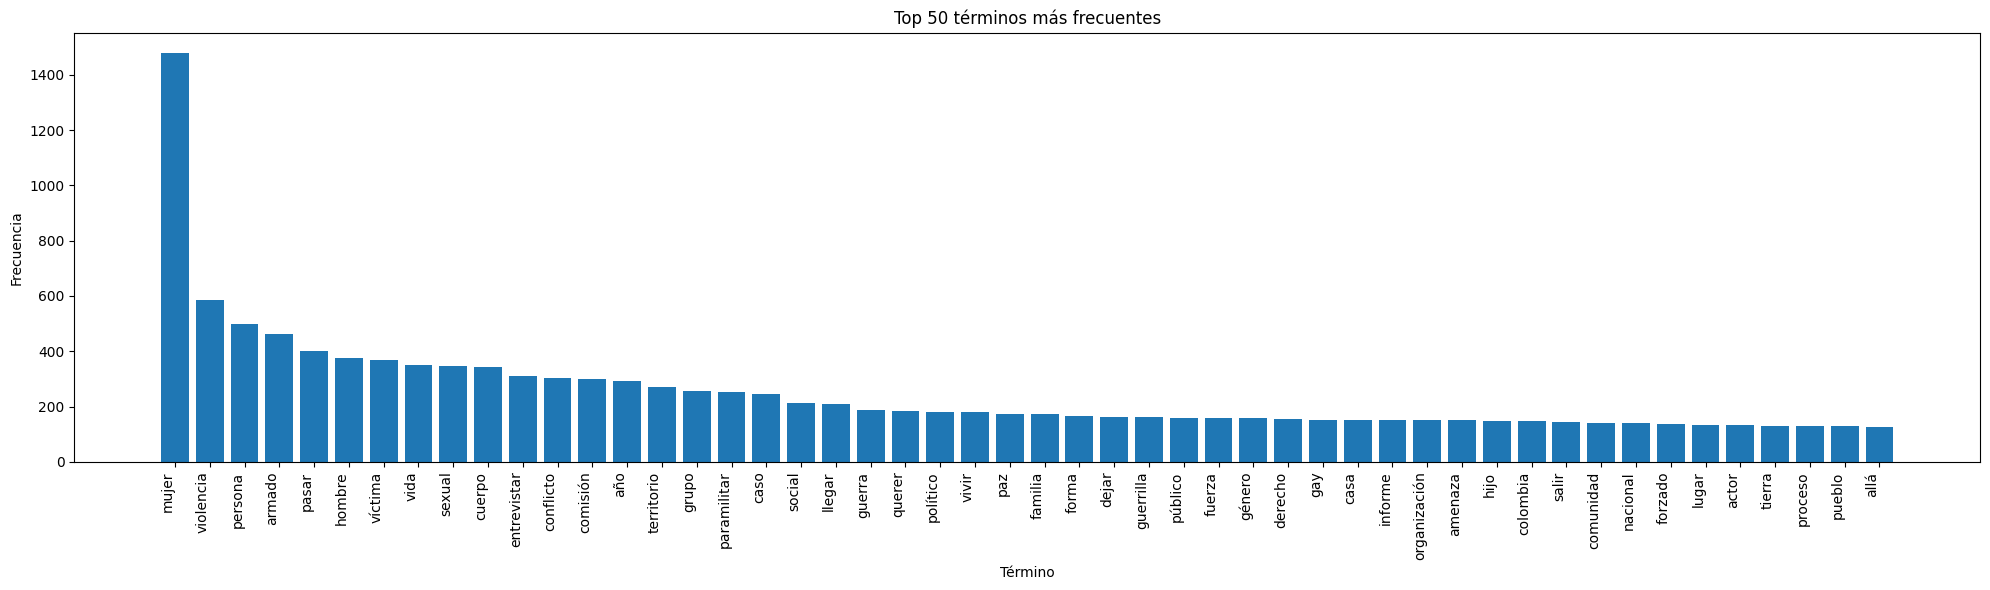

In [4]:
graficar_frecuencias(df_libro, "contenido_preprocesado", top_n=50, min_len=1)

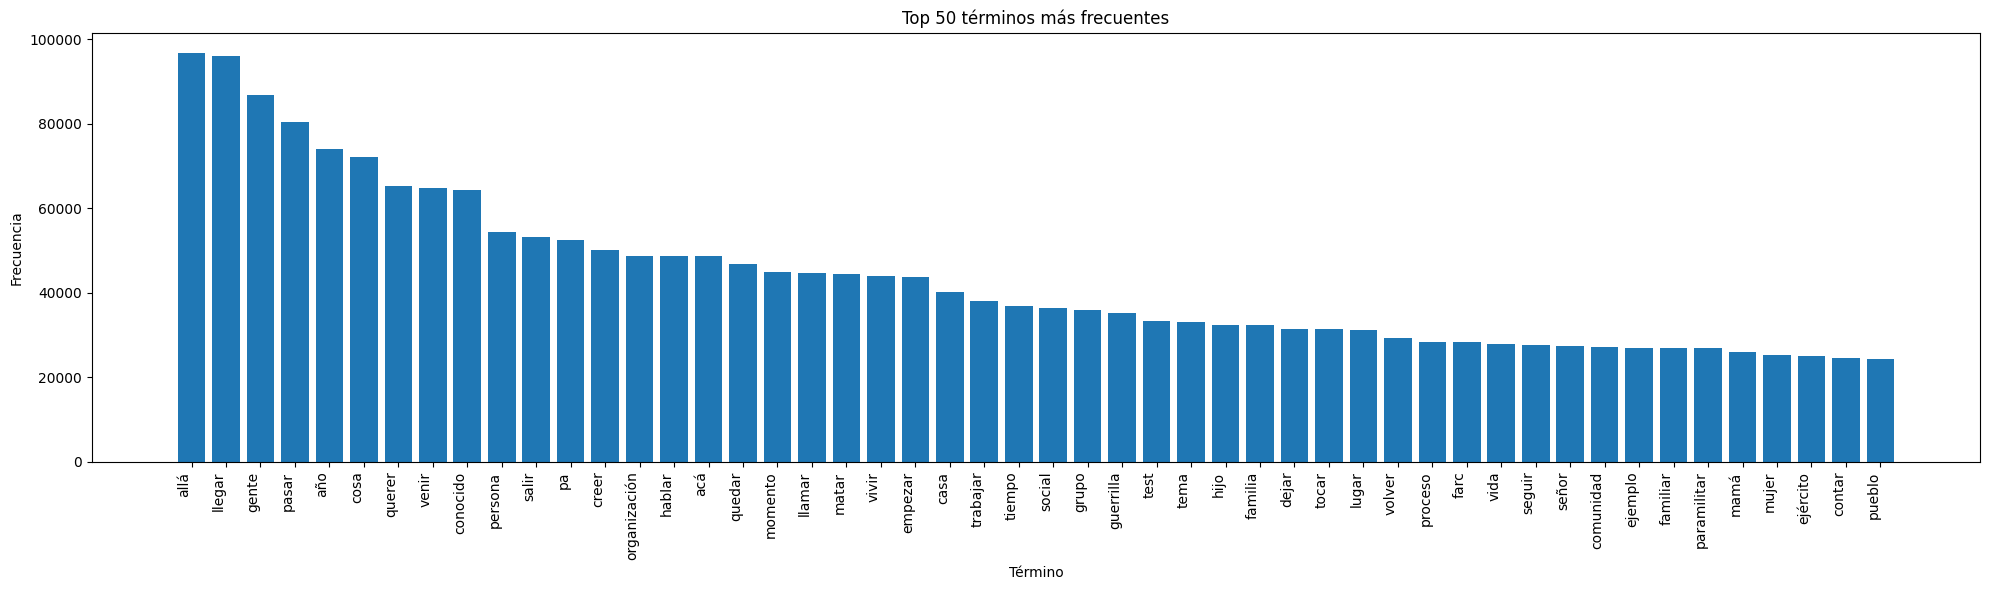

In [5]:
graficar_frecuencias(df_testimonios, "contenido_preprocesado", top_n=50, min_len=1)

### Nube de palabras

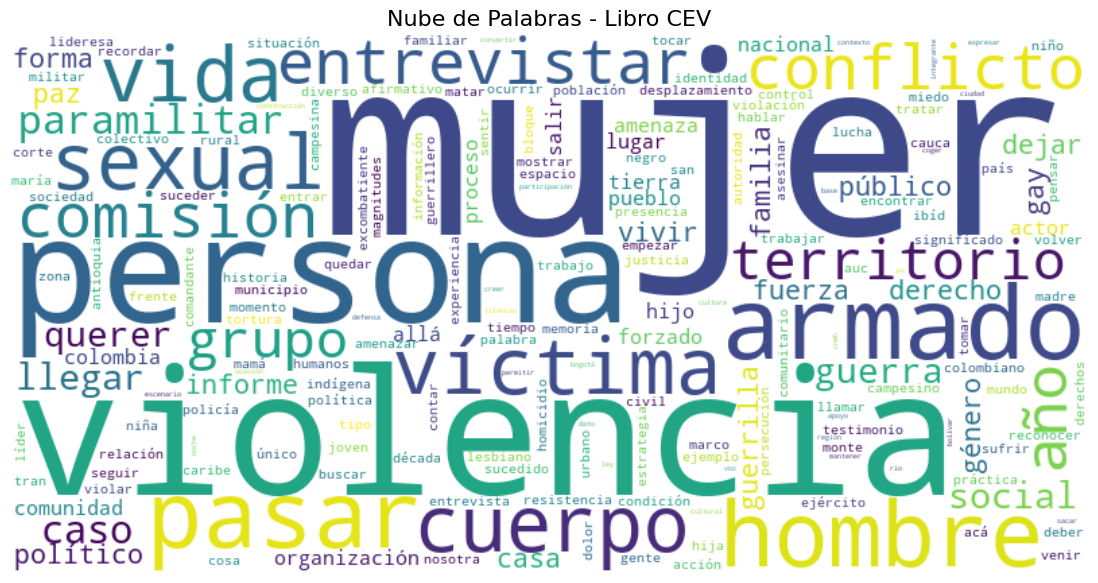

In [3]:
nube_palabras(df_libro, "contenido_preprocesado", min_len=1, titulo="Nube de Palabras - Libro CEV")

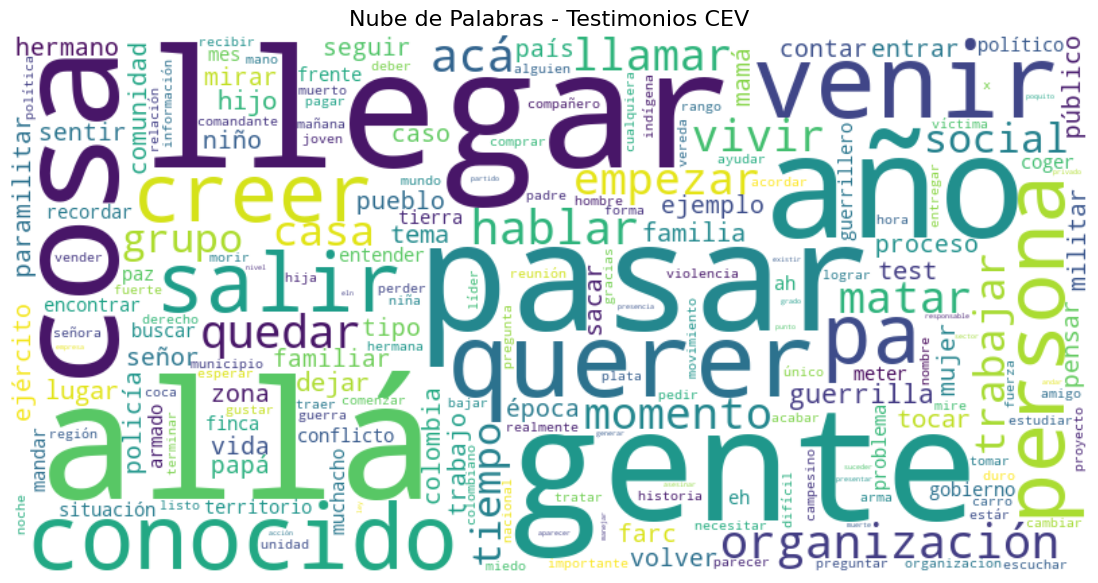

In [4]:
nube_palabras(df_testimonios, "contenido_preprocesado", min_len=1, titulo="Nube de Palabras - Testimonios CEV")

### Diversidad lexica

In [5]:
diversidad_lexica( df_libro, "contenido_preprocesado" , 1)

=== Informe de Diversidad Léxica (Corpus) ===
Tokens totales:       57846
Tipos únicos:         8615
TTR (Type-Token Ratio): 0.1489
RTTR (Root TTR):        35.8194


In [6]:
diversidad_lexica(df_testimonios, "contenido_preprocesado" , 1)

=== Informe de Diversidad Léxica (Corpus) ===
Tokens totales:       9464382
Tipos únicos:         116107
TTR (Type-Token Ratio): 0.0123
RTTR (Root TTR):        37.7409


---
---
## Desarrollo del Modelo de Recuperación de Información

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import ast
import numpy as np
import math
import seaborn as sns

### Transforms data

In [11]:
# Convertir las cadenas de listas de vuelta a listas
df_libro["contenido_preprocesado"] = df_libro["contenido_preprocesado"].apply(ast.literal_eval)
df_testimonios["contenido_preprocesado"] = df_testimonios["contenido_preprocesado"].apply(ast.literal_eval)

In [12]:
# Convertir las listas de listas en texto plano
df_libro["contenido_texto"] = df_libro["contenido_preprocesado"].apply(lambda row: " ".join([word for phrase in row for word in phrase]))
df_testimonios["contenido_texto"] = df_testimonios["contenido_preprocesado"].apply(lambda row: " ".join([word for phrase in row for word in phrase]))

### Crear matriz Tfidf

Se observa un total de 8344 features en la matriz tfidf y un total de 21 secciones que seran las preprocesadas en el libro.

In [13]:
tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(df_libro["contenido_texto"])

In [14]:
print(len(tfidf.get_feature_names_out()))
print(tfidf.get_feature_names_out())

8344
['abadía' 'abajito' 'abajo' ... 'único' 'úrsula' 'útil']


In [15]:
secc_num, feature_num = tfs.shape
feature_names = tfidf.get_feature_names_out()
print("# secciones: %d, n_features: %d" % tfs.shape)

# secciones: 21, n_features: 8344


In [16]:
print("###### Calculo de Feature Names ######")
for x in range(0, feature_num):
    print(" # ", x ," - ",feature_names[x], " \t - ", [tfs[n,x] for n in range(0, secc_num)])

###### Calculo de Feature Names ######
 #  0  -  abadía  	 -  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008375385001461663, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 #  1  -  abajito  	 -  [0.0, 0.0, 0.0, 0.0, 0.0, 0.021050091143258856, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 #  2  -  abajo  	 -  [0.0, 0.0, 0.0, 0.0, 0.0, 0.016756017855219185, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.009341746603356505, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020999641097042037, 0.0]
 #  3  -  abanderada  	 -  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.020590945413691684, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 #  4  -  abanderar  	 -  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008375385001461663, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 #  5  -  abandonado  	 -  [0.008953067458454667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01670913593553866, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 #  6  -  abandonar  	 -

---
---
## Implementación de Métricas de Relevancia

In [17]:
def as_doc(text):
    return [text]
    
response = tfidf.transform(as_doc(df_testimonios["contenido_texto"].iloc[0]))
print('response:', response)

response: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1126 stored elements and shape (1, 8344)>
  Coords	Values
  (0, 8341)	0.0033831009486120197
  (0, 8340)	0.038296671232618866
  (0, 8336)	0.009574167808154717
  (0, 8335)	0.02150017910785846
  (0, 8333)	0.010672330185259728
  (0, 8324)	0.01908296039652176
  (0, 8319)	0.07607725078804004
  (0, 8315)	0.0194359031351501
  (0, 8301)	0.004300035821571692
  (0, 8273)	0.02480908385844852
  (0, 8230)	0.005039293301042544
  (0, 8228)	0.0058975085691969865
  (0, 8227)	0.005039293301042544
  (0, 8219)	0.015242207328273742
  (0, 8216)	0.005336165092629864
  (0, 8210)	0.007621103664136871
  (0, 8207)	0.020977072335181167
  (0, 8206)	0.007621103664136871
  (0, 8205)	0.009574167808154717
  (0, 8204)	0.09574167808154718
  (0, 8194)	0.01417661934768487
  (0, 8190)	0.015242207328273742
  (0, 8188)	0.03372679408960485
  (0, 8178)	0.010672330185259728
  (0, 8176)	0.04012097904132108
  :	:
  (0, 174)	0.0060442877143698425
  (0, 160)	0.0

### Comparacion con entrevistas

In [18]:
def as_doc(text):
    return [text]
    
response = tfidf.transform(as_doc(df_testimonios["contenido_texto"].iloc[0]))
print('response:', response)

response: <Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1126 stored elements and shape (1, 8344)>
  Coords	Values
  (0, 8341)	0.0033831009486120197
  (0, 8340)	0.038296671232618866
  (0, 8336)	0.009574167808154717
  (0, 8335)	0.02150017910785846
  (0, 8333)	0.010672330185259728
  (0, 8324)	0.01908296039652176
  (0, 8319)	0.07607725078804004
  (0, 8315)	0.0194359031351501
  (0, 8301)	0.004300035821571692
  (0, 8273)	0.02480908385844852
  (0, 8230)	0.005039293301042544
  (0, 8228)	0.0058975085691969865
  (0, 8227)	0.005039293301042544
  (0, 8219)	0.015242207328273742
  (0, 8216)	0.005336165092629864
  (0, 8210)	0.007621103664136871
  (0, 8207)	0.020977072335181167
  (0, 8206)	0.007621103664136871
  (0, 8205)	0.009574167808154717
  (0, 8204)	0.09574167808154718
  (0, 8194)	0.01417661934768487
  (0, 8190)	0.015242207328273742
  (0, 8188)	0.03372679408960485
  (0, 8178)	0.010672330185259728
  (0, 8176)	0.04012097904132108
  :	:
  (0, 174)	0.0060442877143698425
  (0, 160)	0.0

In [19]:
cosine_similarity_response =  cosine_similarity(response, tfs)

In [20]:
print("n_question: %d, n_features: %d" % response.shape)
print("cosine_similarity ", cosine_similarity_response)

n_question: 1, n_features: 8344
cosine_similarity  [[0.23927345 0.35324754 0.2409658  0.26410221 0.18034888 0.19233131
  0.23729826 0.09998196 0.25133735 0.23922671 0.18774492 0.25869924
  0.10970607 0.28713049 0.10400472 0.07666309 0.14256311 0.14284579
  0.2181922  0.19777952 0.22523872]]


In [21]:
def compute_similarities(doc):
    # Transform single doc into TF-IDF using the trained vectorizer
    response = tfidf.transform([doc])
    # Cosine similarity vs. all docs in libro
    sims = cosine_similarity(response, tfs)[0]  # [0] to flatten 2D → 1D array
    return sims

# Apply row by row
df_testimonios["cosine_similarities"] = df_testimonios["contenido_texto"].apply(compute_similarities)

In [22]:
df_testimonios["cosine_similarities"].iloc[0]

array([0.23927345, 0.35324754, 0.2409658 , 0.26410221, 0.18034888,
       0.19233131, 0.23729826, 0.09998196, 0.25133735, 0.23922671,
       0.18774492, 0.25869924, 0.10970607, 0.28713049, 0.10400472,
       0.07666309, 0.14256311, 0.14284579, 0.2181922 , 0.19777952,
       0.22523872])

In [23]:
top_n = 5
df_testimonios["top_matches"] = df_testimonios["cosine_similarities"].apply(
    lambda sims: sorted(enumerate(sims), key=lambda x: x[1], reverse=True)[:top_n]
)

In [24]:
df_testimonios["top_matches"].iloc[0]

[(1, 0.35324753731078257),
 (13, 0.2871304890086708),
 (3, 0.26410220958765934),
 (11, 0.2586992418998999),
 (8, 0.2513373536292331)]

### Rocchio

El modelo Rocchio ajusta el vector de consulta en el espacio vectorial (TF-IDF) usando documentos relevantes y no relevantes que el usuario marca.

Interpretación:

* Empiezas con la consulta original.
* Le agregas “peso” de los documentos relevantes.
* Le restas “peso” de los documentos no relevantes.
* Resultado: un query vector modificado, que refleja mejor la intención del usuario.

Es un método de realimentación de relevancia (relevance feedback) que ajusta el vector de consulta en el espacio vectorial.

1.  Tienes un espacio de documentos representados con TF-IDF.

2.  Tomas tu consulta original y la conviertes en vector (q₀).

3.  Rocchio la “mueve” en ese espacio, agregando peso hacia los documentos relevantes y alejándose de los no relevantes:

4.  Una vez obtienes qnuevo, necesitas comparar ese vector contra los documentos → y ahí entra la similitud coseno.

* Cosine Similarity: métrica de comparación entre vectores (cuán “cerca” están dos documentos o una consulta y un documento).

* Rocchio: técnica que modifica la consulta para que, al medir con cosine, los documentos relevantes queden más cerca y los no relevantes más lejos.

In [25]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def rocchio(query_vec, tfs, relevant_idx=None, nonrelevant_idx=None, alpha=1.0, beta=0.75, gamma=0.15):
    """
    query_vec: vector TF-IDF de la consulta (1 x n_features)
    tfs: matriz TF-IDF de todos los documentos (n_docs x n_features)
    relevant_idx: lista de índices de docs relevantes
    nonrelevant_idx: lista de índices de docs no relevantes
    """
    q0 = query_vec.toarray()[0]
    q_new = alpha * q0

    if relevant_idx:
        q_new += beta * np.mean(tfs[relevant_idx].toarray(), axis=0)

    if nonrelevant_idx:
        q_new -= gamma * np.mean(tfs[nonrelevant_idx].toarray(), axis=0)

    return q_new.reshape(1, -1)

In [26]:
# Aplicar a todas las entrevistas
all_rocchio_scores = []
all_rocchio_top = []

for query in df_testimonios["contenido_texto"]:
    q_vec = tfidf.transform([query])

    # Nota: si no defines relevantes/no relevantes, usamos solo q0 (consulta original)
    q_new = rocchio(q_vec, tfs, relevant_idx=[], nonrelevant_idx=[])

    # Similitud coseno entre la nueva consulta y todo libro
    scores = cosine_similarity(q_new, tfs)[0]
    all_rocchio_scores.append(scores)

    # Top-5 documentos más similares
    top5 = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:5]
    all_rocchio_top.append(top5)

df_testimonios["rocchio"] = all_rocchio_scores
df_testimonios["rocchio_top"] = all_rocchio_top


In [27]:
df_testimonios["rocchio"].iloc[0]

array([0.23927345, 0.35324754, 0.2409658 , 0.26410221, 0.18034888,
       0.19233131, 0.23729826, 0.09998196, 0.25133735, 0.23922671,
       0.18774492, 0.25869924, 0.10970607, 0.28713049, 0.10400472,
       0.07666309, 0.14256311, 0.14284579, 0.2181922 , 0.19777952,
       0.22523872])

In [28]:
df_testimonios["rocchio_top"].iloc[0]

[(1, 0.3532475373107833),
 (13, 0.2871304890086708),
 (3, 0.26410220958765956),
 (11, 0.25869924189989996),
 (8, 0.25133735362923315)]

In [29]:
df_testimonios["rocchio_top"]

0       [(1, 0.3532475373107833), (13, 0.2871304890086...
1       [(8, 0.3382385449470131), (3, 0.31420984173693...
2       [(1, 0.3298399836061663), (11, 0.3185238423015...
3       [(18, 0.38285406104429953), (19, 0.34976598466...
4       [(3, 0.30265209466895704), (8, 0.2864505150960...
                              ...                        
2211    [(1, 0.288410166768632), (0, 0.263415158400402...
2212    [(18, 0.269061565161837), (13, 0.2644443391722...
2213    [(18, 0.30803806733076583), (1, 0.304224492359...
2214    [(2, 0.3375898416983896), (1, 0.31929619505857...
2215    [(0, 0.25441388682072996), (2, 0.2541800720410...
Name: rocchio_top, Length: 2216, dtype: object

### Okapi BM25
BM25 es un modelo probabilístico basado en frecuencia de términos (no en TF-IDF).
Para cada término de la consulta mide qué tan representativo es en el documento, ajustando por:

Longitud del documento (∣𝑑∣): documentos más largos no deben dar ventaja injusta.

Frecuencia del término en el documento (𝑓(𝑡,𝑑).

IDF (inversa de frecuencia de documento): términos poco frecuentes en la colección tienen más peso.

Interpretación:

* Si un término aparece mucho en un documento, la relevancia aumenta pero se
satura (no crece infinito).
* Documentos largos se penalizan ligeramente.
* Palabras raras en la colección (alto IDF) pesan más.

In [30]:
import math

def compute_idf(corpus_tokens):
    """
    Calcula los valores IDF para cada término del corpus.
    corpus_tokens: lista de listas de palabras por documento
    """
    N = len(corpus_tokens)
    df = {}
    for doc in corpus_tokens:
        for term in set(doc):  # contamos solo 1 vez por doc
            df[term] = df.get(term, 0) + 1
    idf = {term: math.log((N - df[term] + 0.5) / (df[term] + 0.5) + 1) for term in df}
    return idf

def bm25_score(query_tokens, doc_tokens, idf, avgdl, k1=1.5, b=0.75):
    """
    Calcula BM25 entre una consulta y un documento.
    """
    score = 0.0
    doc_len = len(doc_tokens)

    # frecuencias de términos en el documento
    freqs = {}
    for term in doc_tokens:
        freqs[term] = freqs.get(term, 0) + 1

    for term in query_tokens:
        if term not in idf:
            continue
        f = freqs.get(term, 0)
        if f == 0:
            continue
        denom = f + k1 * (1 - b + b * doc_len / avgdl)
        score += idf[term] * (f * (k1 + 1)) / denom
    return score

def bm25_pipeline(corpus_tokens, query_tokens, k1=1.5, b=0.75):
    """
    Calcula BM25 de una consulta contra todo el corpus.
    """
    idf = compute_idf(corpus_tokens)
    avgdl = sum(len(doc) for doc in corpus_tokens) / len(corpus_tokens)

    scores = [bm25_score(query_tokens, doc, idf, avgdl, k1, b) for doc in corpus_tokens]
    return scores

In [31]:
# Para LIBRO
df_libro["contenido_tokens"] = df_libro["contenido_preprocesado"].apply(
    lambda row: [word for phrase in row for word in phrase]
)

# Para ENTREVISTAS
df_testimonios["contenido_tokens"] = df_testimonios["contenido_preprocesado"].apply(
    lambda row: [word for phrase in row for word in phrase]
)

all_bm25_scores = []
all_bm25_top = []

idf = compute_idf(df_libro["contenido_tokens"])
avgdl = sum(len(doc) for doc in df_libro["contenido_tokens"]) / len(df_libro["contenido_tokens"])

for query in df_testimonios["contenido_tokens"]:
    scores = [bm25_score(query, doc, idf, avgdl) for doc in df_libro["contenido_tokens"]]
    all_bm25_scores.append(scores)

    top5 = sorted(enumerate(scores), key=lambda x: x[1], reverse=True)[:5]
    all_bm25_top.append(top5)

df_testimonios["bm25"] = all_bm25_scores
df_testimonios["bm25_top"] = all_bm25_top

In [32]:
df_testimonios["bm25_top"].iloc[0]

[(1, 2618.6281489861217),
 (9, 2037.8642695101812),
 (2, 1922.3124241399055),
 (13, 1791.6453402345965),
 (0, 1782.2314346195428)]

---
---
## Comparacion corpus


Diferencias en escala

1.  TF-IDF + Cosine / Rocchio

* El cosine_similarity siempre devuelve valores en el rango [0, 1].

* 1 = vectores idénticos, 0 = no comparten nada.

* Es una métrica normalizada → siempre acotada.

2.  BM25

* Los valores no están normalizados.

* Cada término contribuye al score de manera acumulativa.

* Cuantos más términos de la consulta aparecen en el documento (y con alta frecuencia), más grande el score.

* Escala depende de:

  *  Tamaño de la consulta (más palabras → score más alto).

  * Frecuencias de los términos.

  * Valores de los hiperparámetros
  
* No tiene un límite superior fijo: 5, 10, 20 o más son posibles.

In [33]:
def extract_doc_ids(column):
    return [doc_id for row in df_testimonios[column] for doc_id, score in row]

# Listas con los doc_ids que aparecen en Top-5
cosine_docs = extract_doc_ids("top_matches")
rocchio_docs = extract_doc_ids("rocchio_top")
bm25_docs   = extract_doc_ids("bm25_top")

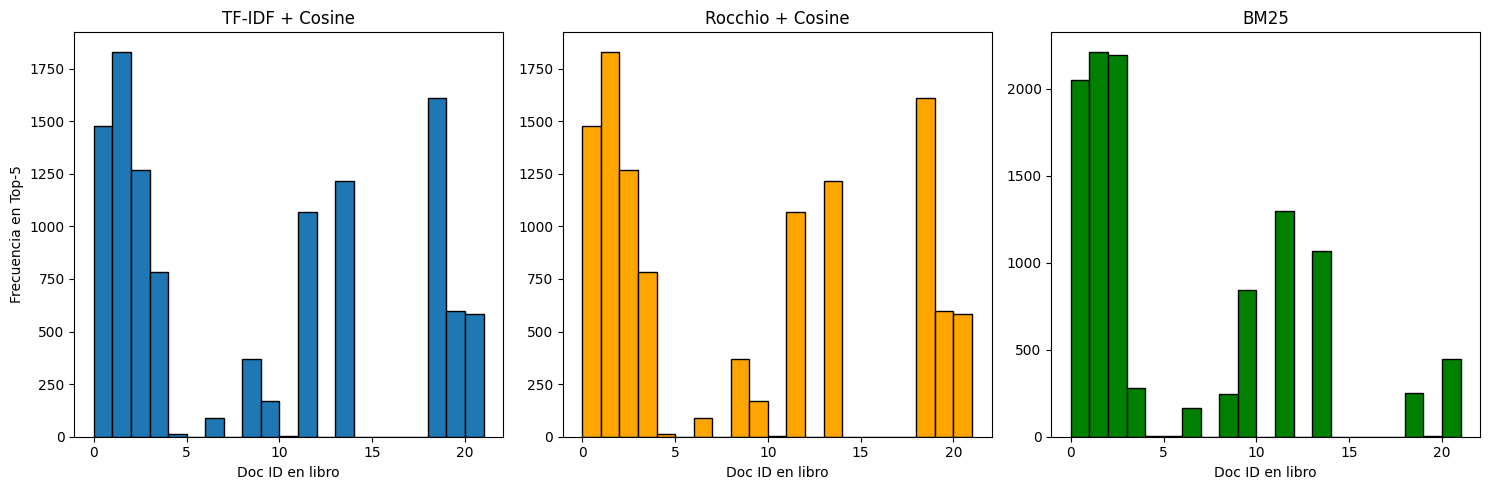

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

# --- TF-IDF + Cosine ---
plt.subplot(1,3,1)
plt.hist(cosine_docs, bins=range(len(df_libro)+1), edgecolor="black")
plt.title("TF-IDF + Cosine")
plt.xlabel("Doc ID en libro")
plt.ylabel("Frecuencia en Top-5")

# --- Rocchio ---
plt.subplot(1,3,2)
plt.hist(rocchio_docs, bins=range(len(df_libro)+1), edgecolor="black", color="orange")
plt.title("Rocchio + Cosine")
plt.xlabel("Doc ID en libro")

# --- BM25 ---
plt.subplot(1,3,3)
plt.hist(bm25_docs, bins=range(len(df_libro)+1), edgecolor="black", color="green")
plt.title("BM25")
plt.xlabel("Doc ID en libro")

plt.tight_layout()
plt.show()


In [35]:
def build_top5_matrix(df, column_name, n_docs):
    """
    Construye una matriz (entrevistas x documentos) con los scores de los top-5.
    df: DataFrame de entrevistas
    column_name: "top_matches", "rocchio_top" o "bm25_top"
    n_docs: número de documentos en libro
    """
    matrix = np.zeros((len(df), n_docs))
    for i, row in enumerate(df[column_name]):
        for doc_id, score in row:
            matrix[i, doc_id] = score
    return pd.DataFrame(matrix, index=[f"E{i}" for i in range(len(df))],
                        columns=[f"S{j}" for j in range(n_docs)])


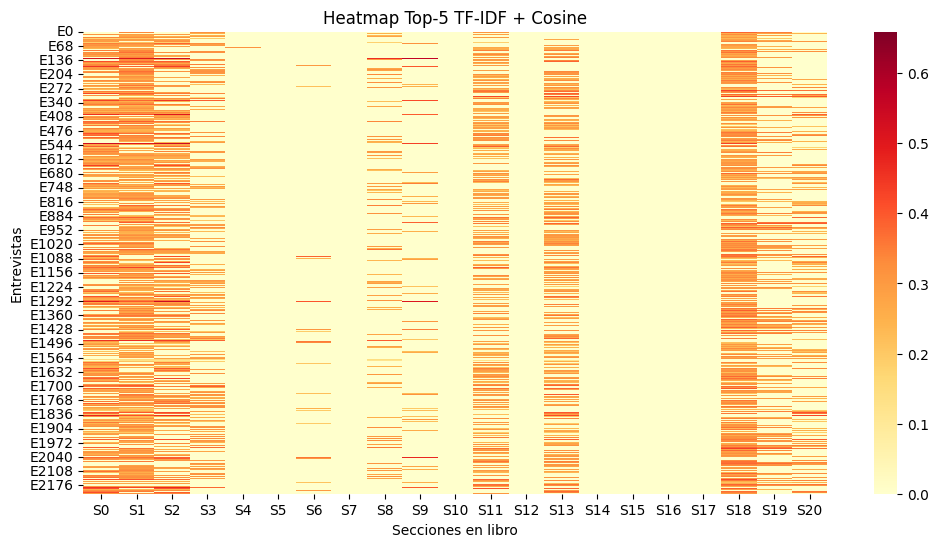

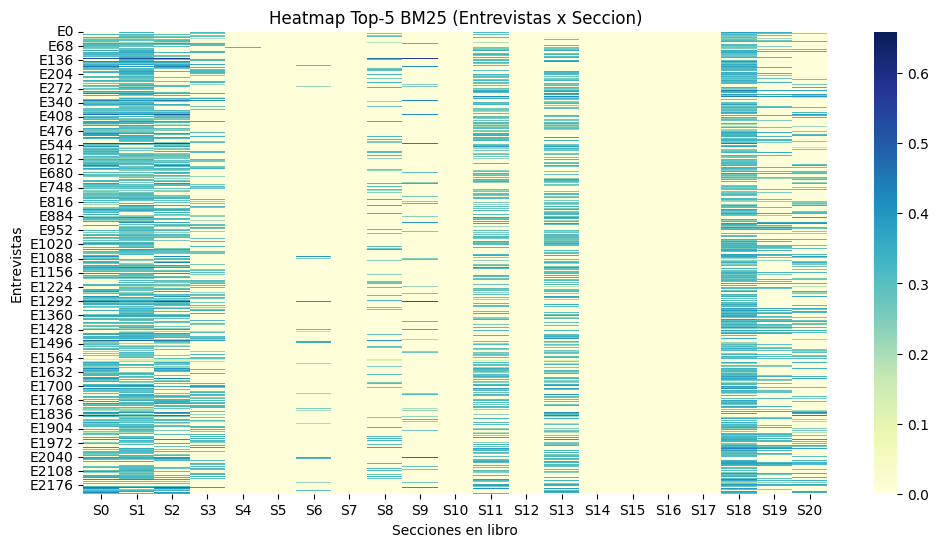

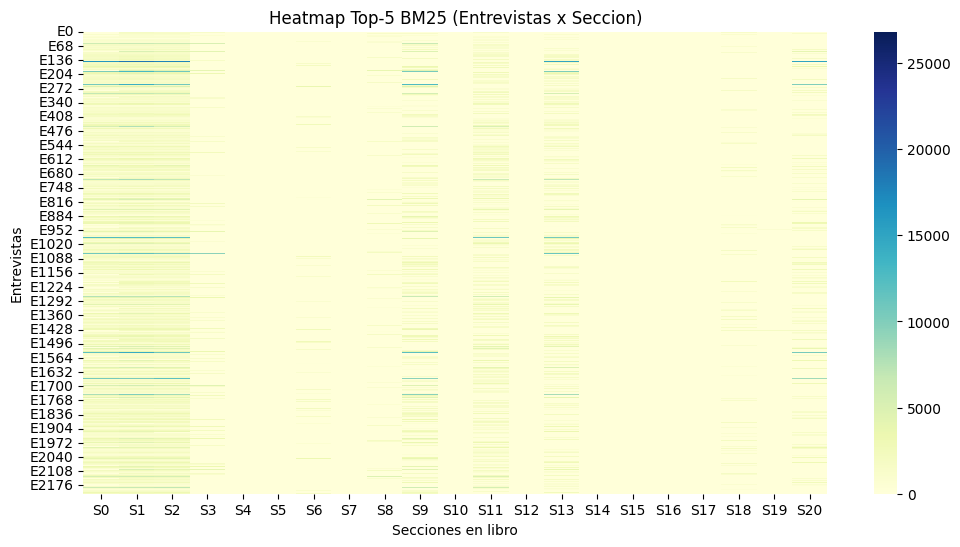

In [36]:
cosine_matrix = build_top5_matrix(df_testimonios, "top_matches", len(df_libro))
rocchio_matrix = build_top5_matrix(df_testimonios, "rocchio_top", len(df_libro))
bm25_matrix = build_top5_matrix(df_testimonios, "bm25_top", len(df_libro))

# Ejemplo para Cosine
plt.figure(figsize=(12,6))
sns.heatmap(cosine_matrix, cmap="YlOrRd", annot=False, cbar=True)
plt.title("Heatmap Top-5 TF-IDF + Cosine")
plt.xlabel("Secciones en libro")
plt.ylabel("Entrevistas")
plt.show()

# Construir matriz para Rocchio
bm25_matrix = build_top5_matrix(df_testimonios, "bm25_top", len(df_libro))

plt.figure(figsize=(12,6))
sns.heatmap(rocchio_matrix, cmap="YlGnBu", annot=False, cbar=True)
plt.title("Heatmap Top-5 BM25 (Entrevistas x Seccion)")
plt.xlabel("Secciones en libro")
plt.ylabel("Entrevistas")
plt.show()

# Construir matriz para BM25
bm25_matrix = build_top5_matrix(df_testimonios, "bm25_top", len(df_libro))

plt.figure(figsize=(12,6))
sns.heatmap(bm25_matrix, cmap="YlGnBu", annot=False, cbar=True)
plt.title("Heatmap Top-5 BM25 (Entrevistas x Seccion)")
plt.xlabel("Secciones en libro")
plt.ylabel("Entrevistas")
plt.show()


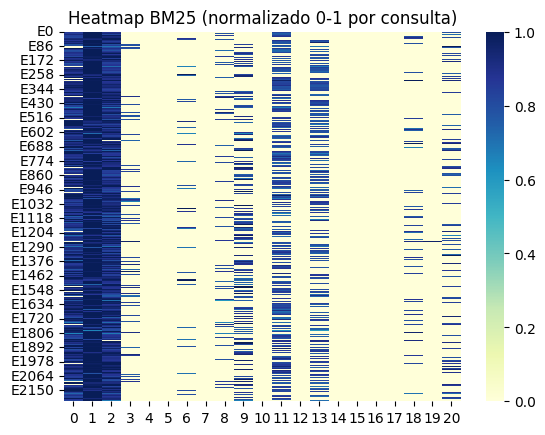

In [37]:
from sklearn.preprocessing import minmax_scale

# Normalizamos la matriz BM25 fila por fila (cada query)
bm25_matrix_norm = bm25_matrix.apply(lambda row: minmax_scale(row), axis=1, result_type="expand")

sns.heatmap(bm25_matrix_norm, cmap="YlGnBu")
plt.title("Heatmap BM25 (normalizado 0-1 por consulta)")
plt.show()

In [38]:
import numpy as np
import pandas as pd

def build_top5_count_matrix(df, column_name, n_docs):
    """
    Construye una matriz (entrevistas x documentos) con la frecuencia de aparición en Top-5.
    df: DataFrame de entrevistas
    column_name: "top_matches", "rocchio_top" o "bm25_top"
    n_docs: número de documentos en libro
    """
    matrix = np.zeros((len(df), n_docs))
    for i, row in enumerate(df[column_name]):
        for doc_id, _ in row:   # ignoramos score, solo doc_id
            matrix[i, doc_id] += 1
    return pd.DataFrame(matrix, index=[f"E{i}" for i in range(len(df))],
                        columns=[f"S{j}" for j in range(n_docs)])


In [39]:
cosine_count = build_top5_count_matrix(df_testimonios, "top_matches", len(df_libro))
rocchio_count = build_top5_count_matrix(df_testimonios, "rocchio_top", len(df_libro))
bm25_count   = build_top5_count_matrix(df_testimonios, "bm25_top", len(df_libro))

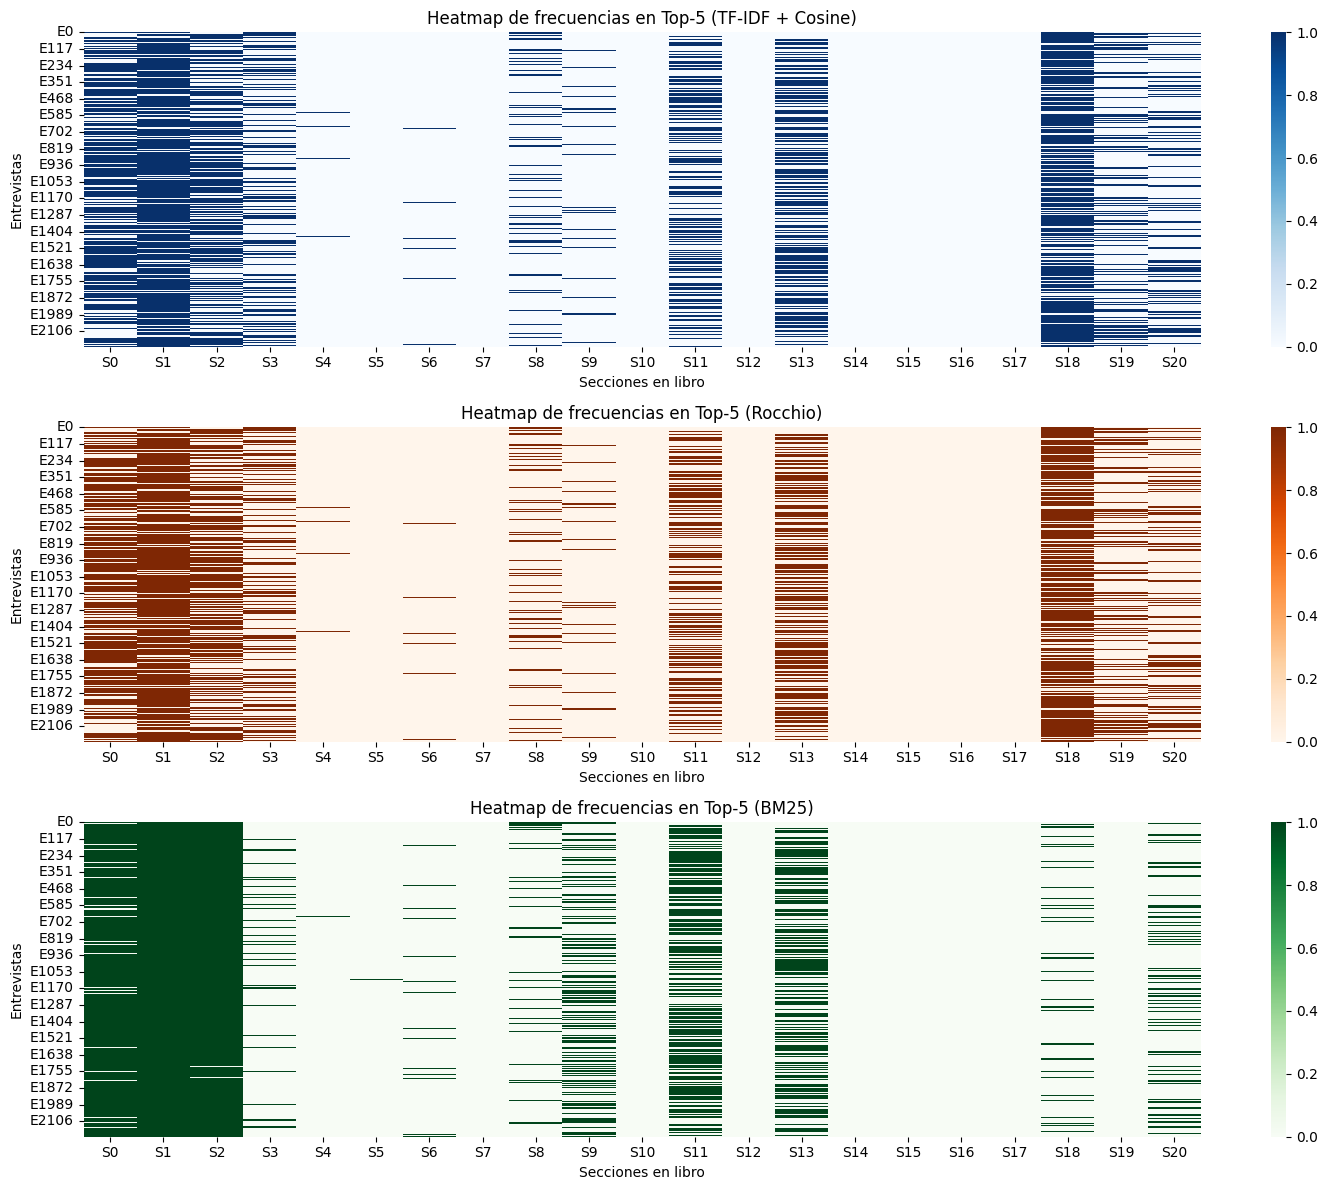

In [40]:
plt.figure(figsize=(15,12))

# --- TF-IDF + Cosine ---
plt.subplot(3,1,1)
sns.heatmap(cosine_count, cmap="Blues", cbar=True, annot=False)
plt.title("Heatmap de frecuencias en Top-5 (TF-IDF + Cosine)")
plt.xlabel("Secciones en libro")
plt.ylabel("Entrevistas")

# --- Rocchio ---
plt.subplot(3,1,2)
sns.heatmap(rocchio_count, cmap="Oranges", cbar=True, annot=False)
plt.title("Heatmap de frecuencias en Top-5 (Rocchio)")
plt.xlabel("Secciones en libro")
plt.ylabel("Entrevistas")

# --- BM25 ---
plt.subplot(3,1,3)
sns.heatmap(bm25_count, cmap="Greens", cbar=True, annot=False)
plt.title("Heatmap de frecuencias en Top-5 (BM25)")
plt.xlabel("Secciones en libro")
plt.ylabel("Entrevistas")

plt.tight_layout()
plt.show()


In [41]:
df_libro

,seccion,seccion_principal,subseccion,contenido,contenido_preprocesado,contenido_texto,contenido_tokens
0,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,"La guerra, el territorio y las mujeres",Las mujeres viven la guerra en sus territorios...,"[[mujer, vivir, guerra, territorio, vida, cuer...",mujer vivir guerra territorio vida cuerpo cual...,"[mujer, vivir, guerra, territorio, vida, cuerp..."
1,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,Las violencias sexuales y reproductivas contra...,Duele la lengua rota. \n¿Dónde está mi femenin...,"[[doler, lengua, roto], [femenino], [lengua, s...",doler lengua roto femenino lengua silencio len...,"[doler, lengua, roto, femenino, lengua, silenc..."
2,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,Mujeres políticas expulsadas de la democracia,».\n\n¿qué pasó? significados y magnitudes de ...,"[[], [pasar, significado, magnitudes, sucedido...",pasar significado magnitudes sucedido incoro t...,"[pasar, significado, magnitudes, sucedido, inc..."
3,Mujeres,¿Qué pasó? Significados y magnitudes de lo su...,Las mujeres en la guerra: vinculación e impact...,Para algunas mujeres campesinas y de las clase...,"[[mujer, campesino, clase, popular, urbano, vi...",mujer campesino clase popular urbano vincular ...,"[mujer, campesino, clase, popular, urbano, vin..."
4,Mujeres,¿Por qué pasó? Dimensiones del patriarcado,"El contínuum de violencias, una realidad que c...",El contínuum se refiere a la persistencia de l...,"[[contínuum, referir, persistencia, violencia,...",contínuum referir persistencia violencia mujer...,"[contínuum, referir, persistencia, violencia, ..."
5,Mujeres,¿Por qué pasó? Dimensiones del patriarcado,El mandato de las masculinidades guerreras y s...,El concepto de masculinidades guerreras alude ...,"[[concepto, masculinidad, guerrera, aludir, ex...",concepto masculinidad guerrera aludir experien...,"[concepto, masculinidad, guerrera, aludir, exp..."
6,Mujeres,¿Por qué pasó? Dimensiones del patriarcado,La desprotección por parte del Estado en zonas...,Colombia es un país profundamente desigual en ...,"[[colombia, país, profundamente, desigual, tér...",colombia país profundamente desigual término i...,"[colombia, país, profundamente, desigual, térm..."
7,Mujeres,¿Qué pasó con lo que pasó?,Impactos del conflicto armado en las mujeres,fueron desproporcionados justamente \npor la e...,"[[desproporcionar, justamente, existencia, pre...",desproporcionar justamente existencia previo p...,"[desproporcionar, justamente, existencia, prev..."
8,Mujeres,¿Qué pasó con lo que pasó?,Afrontamientos de las mujeres víctimas,Resistir en medio de la guerra es trabajo de l...,"[[resistir, guerra, trabajo, defensora, vida, ...",resistir guerra trabajo defensora vida contene...,"[resistir, guerra, trabajo, defensora, vida, c..."
9,Mujeres,¿Qué pasó con lo que pasó?,"Resistencias, juntanza y organización: en las ...",Las mujeres víctimas en Colombia se han sobrep...,"[[mujer, víctima, colombia, sobreponer, trayec...",mujer víctima colombia sobreponer trayectoria ...,"[mujer, víctima, colombia, sobreponer, trayect..."
